In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="4,5,6,7"

# Full wave inversion

In [1]:
from jax import numpy as jnp
import numpy as np
from matplotlib import pyplot as plt
import jax
from livelossplot import PlotLosses

In [2]:
# Defining geometry
from jwave.geometry import kGrid, TimeAxis, Medium, Sources, Sensors, _points_on_circle, _circ_mask
from jwave.physics import simulate_wave_propagation
from jwave.signal_processing import gaussian_window, apply_ramp

N = (256,)
dx = (.5,)
source_freq = .3

grid = kGrid.make_grid(N, dx)
output_time_array = TimeAxis(dt=0.1, t_end=250.)
t = jnp.arange(0, output_time_array.t_end, output_time_array.dt)

s1 = jnp.sin(2 * jnp.pi * source_freq * t)

In [3]:
@jax.jit
def get_trace(block_sos):
    sound_speed = jnp.ones(N) 
    sound_speed = sound_speed.at[80:150].set(block_sos)
    medium = Medium(
        sound_speed=sound_speed,
        density=1.,
        attenuation=.0,
        pml_size=20
    )
    
    # define a source point
    source_mag = 5/output_time_array.dt
    center = 5
    s1 = source_mag * jnp.sin(2 * jnp.pi * source_freq * t)
    signal = gaussian_window(apply_ramp(s1, output_time_array.dt, source_freq), t, center, 8)

    source_positions = ([40],)
    sources = Sources(source_positions, signal)

    # Define sensors
    sensors_positions = ([220],)
    sensors = Sensors(positions=sensors_positions)
    
    # Get signals
    traces = simulate_wave_propagation(grid, medium, output_time_array, sources, sensors,
                                  output_t_axis = output_time_array, backprop=True)
    return traces[1][500:2000,0,0]

In [4]:
ref_trace = get_trace(1.5)

In [5]:
plt.plot(ref_trace)

In [6]:
sos_trials = jnp.linspace(1.,2.,128)

In [7]:
def mse_loss(block_sos):
    prop_trace = get_trace(block_sos)
    return jnp.mean(jnp.abs(prop_trace/jnp.std(ref_trace) - ref_trace/jnp.std(ref_trace))**2)

sos_trials = jnp.linspace(1.,2.,128)

In [8]:
errors_ls = jax.vmap(mse_loss)(sos_trials)

In [9]:
ref_trace = get_trace(1.5)

def env_loss(block_sos):
    prop_trace = get_trace(block_sos)
    x = jnp.fft.fft(prop_trace)
    x = x.at[len(x)//2:].set(0.)
    prop_trace = jnp.abs(jnp.fft.ifft(x))
    
    x = jnp.fft.fft(ref_trace)
    x = x.at[len(x)//2:].set(0.)
    x = jnp.abs(jnp.fft.ifft(x))
    
    return jnp.mean(jnp.abs(prop_trace/jnp.std(x) - x/jnp.std(x))**2)

In [10]:
errors = jax.vmap(env_loss)(sos_trials)

In [11]:
plt.plot(sos_trials,errors)
plt.plot(sos_trials,errors_ls)
#plt.ylim([0,150])

## Setup the problem

In [12]:
from jwextras.matlab import Matlab

In [13]:
mlb = Matlab()
mlb.start()

Connecting to Matlab session MATLAB_290684


In [20]:
mlb.run("clearvars")
mlb.add('/home/astanziola/repos/jwaverepo/docs/examples/_data/CT.nii', "ct_location")
#mlb.add('/home/antonios/repos/jwave/docs/examples/_data/CT.nii', "ct_location")
mlb.run("addpath(genpath('~/repos/k-plan-qms-sem/'))")

In [21]:
mlb.run_script("_matlab/fwi_setup.m")

In [22]:
# Assign variables from MATLAB workspace (which exists as a Python dictionary)
Nx = int(mlb.get("Nx"))
Ny = int(mlb.get("Ny"))
dx = float(mlb.get("dx"))
dy = float(mlb.get("dy"))
sound_speed = jnp.asarray(mlb.get("sound_speed"))
attenuation = jnp.asarray(mlb.get("attenuation"))*0. # ???
skull_mask = jnp.asarray(mlb.get("skull_mask"), dtype=float)
brain_mask = jnp.asarray(mlb.get("brain_mask"), dtype=float)

# Print grid size
print("Nx={}, Ny={}".format(Nx, Ny))

# Create grid
N = (Nx, Ny)
d = (dx, dy)
grid = kGrid.make_grid(N, d)

Nx=256, Ny=256


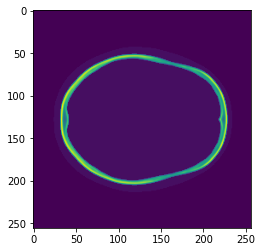

In [23]:
plt.imshow(sound_speed)

In [24]:
cfl = 0.25

# Physical properties
medium = Medium(
    sound_speed=sound_speed,
    density=jnp.ones(N),
    attenuation=0.0,
    pml_size=15
)

time_array = TimeAxis.from_kgrid(grid, medium, cfl=cfl, t_end=1e-3)
output_time_array = time_array

In [25]:
t = jnp.arange(0, time_array.t_end, time_array.dt)
t.shape

(10352,)

In [26]:
# define a source point
from jwave.signal_processing import gaussian_window, apply_ramp

num_sources = 64
source_freq = 500e3
source_mag = 5/time_array.dt


t = jnp.arange(0, time_array.t_end, time_array.dt)
center = 8e-6
s1 = source_mag * jnp.sin(2 * jnp.pi * source_freq * t)
signal = gaussian_window(apply_ramp(s1, output_time_array.dt, source_freq), t, center, 3e-6)

mask = _circ_mask(N, 128-21, (128,129))
x, y = _points_on_circle(num_sources, 128-21, (128,129))
source_positions = (jnp.array(x), jnp.array(y))

In [27]:
# Define sensors
x, y = _points_on_circle(num_sources, 128-21, (128,129), angle=np.pi/num_sources)
sensors_positions = (x, y)
sensors = Sensors(positions=sensors_positions)

Let's look at the problem setup

In [28]:
# Show simulation setup
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1,2,figsize=(15,4), gridspec_kw={'width_ratios': [1, 2]})

ax[0].imshow(medium.sound_speed, cmap="cividis")
ax[0].scatter(source_positions[1],source_positions[0], c='r', marker='x', label="sources")
ax[0].scatter(sensors_positions[1],sensors_positions[0], c='g', marker='.', label="sensors")
ax[0].legend()
ax[0].set_title("Speed of sound")
ax[0].axis("off")

ax[1].plot(signal[:400], label="Source 1", c='k')
ax[1].set_title("Source signals")
ax[1].get_yaxis().set_visible(False)

In [29]:
jnp.amax(medium.sound_speed)

DeviceArray(2587.9282, dtype=float32)

#### Run the simulation

In [30]:
from functools import partial
import jax

src_signal = jnp.stack([signal])

@jax.jit
def single_source_simulation(speed_of_sound,source_num):
    # Setting source
    x = jax.lax.dynamic_slice(source_positions[0], (source_num,), (1,))
    y = jax.lax.dynamic_slice(source_positions[1], (source_num,), (1,))
    sources = Sources((x,y), src_signal)
    medium = Medium(
        sound_speed=speed_of_sound,
        density=1.0,
        attenuation=0.0,
        pml_size=15
    )
    
    # Run simulations
    fields = simulate_wave_propagation(grid, medium, time_array, sources, sensors, backprop=True)
    
    # Return pressure
    p = jnp.sum(fields[1],1)*(medium.sound_speed[sources.positions]**2)
    return p

batch_simulations = jax.jit(jax.vmap(single_source_simulation, (None,0), 0))

In [31]:
p_data = batch_simulations(medium.sound_speed, jnp.arange(num_sources))
p_data = p_data + 50*jax.random.normal(jax.random.PRNGKey(42), p_data.shape)
print(p_data.shape)

(64, 10353, 64)


In [48]:
plt.figure(figsize=(25,4))
plt.plot(t, p_data[0,:-1,8])
plt.xlim(t[0], t[-1])

pp = p_data[0,:-1,8]
print(pp.shape, len(pp)//2)
x = jnp.fft.fft(pp, axis=0)
x = 2*x.at[len(pp)//2:].set(0.)
x = jnp.abs(jnp.fft.ifft(x, axis=0))
plt.plot(t, x)  

(10352,) 5176


In [34]:
# Run simulation
p = single_source_simulation(medium.sound_speed, 1)

In [35]:
%%timeit
single_source_simulation(medium.sound_speed, 1)

875 ms ± 3.65 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [79]:
%%timeit
batch_simulations(medium.sound_speed, jnp.arange(4))

1.57 s ± 5.06 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Define the optimization problem

In [36]:
from jax import random, nn, value_and_grad, jit, jvp, grad, vmap, jacfwd
from jax import lax
from jax.experimental import stax
from jwave.signal_processing import smooth, apply_ramp

key = random.PRNGKey(42)

In [37]:
def get_sound_speed(params):
    return 1509*jnp.ones(N) + 1500*(nn.sigmoid(params)-0.1)*mask

In [43]:
def init_sos():
    old_sos_params = 0.*medium.sound_speed - 2.
    return old_sos_params
params = init_sos()
sos = get_sound_speed(params)

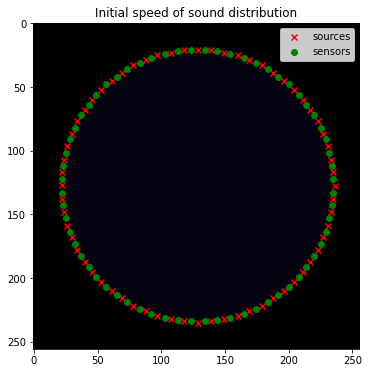

In [44]:
def plot_sos(sos, ax = None):
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(8,6))

        ax.imshow(sos, cmap="inferno", vmax=2500)
        ax.scatter(source_positions[1],source_positions[0], c='r', marker='x', label="sources")
        ax.scatter(sensors_positions[1],sensors_positions[0], c='g', marker='o', label="sensors")
        ax.legend()

plot_sos(sos)
plt.title("Initial speed of sound distribution")
plt.show()

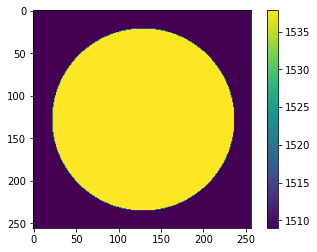

In [45]:
plt.imshow(sos)
plt.colorbar()

In [49]:
def loss_func(p, source_num):
    '''
    Maximizes energy at central sensor, minimize energy external ones'''
    diff = p_data[source_num] - p
    return 1e3*jnp.mean(jnp.abs(diff)**2)

def corr_loss(p, source_num):
    x = jnp.fft.fft(p, axis=0)
    x = x.at[len(x)//2:,:].set(0.)
    x = jnp.fft.ifft(x, axis=0)
    prop_trace = x/(1e2 + jnp.abs(x))
    
    x = jnp.fft.fft(p_data[source_num], axis=0)
    x = x.at[len(x)//2:,:].set(0.)
    x = jnp.fft.ifft(x, axis=0)
    x = x/(1e2 + jnp.abs(x))
    
    return jnp.abs(jnp.mean((jnp.conj(x)*x)))

                
def get_sensor_signals(speed_of_sound, source_num):
    p = single_source_simulation(speed_of_sound, source_num)
    return p

def tv(sos):
    horiz = sos[1:,:]-sos[:-1,:]
    vertical = sos[:,1:]-sos[:,:-1]
    return jnp.mean(jnp.sqrt(1e-7 + horiz[:,1:]**2 + vertical[1:,:]**2))

def loss_with_grad(params, source_num):
    
    def loss(params):
        sos = get_sound_speed(params)
        traces = get_sensor_signals(sos, source_num)
        data_loss = env_loss(traces, source_num)
        total_variation = tv(sos)
        return data_loss + total_variation, total_variation
        
    [lossval, total_variation], gradient = value_and_grad(loss, has_aux=True)(params)
    return lossval, total_variation, gradient

In [50]:
def gauss(N: int, std: float):
    r"""Returns the blackman window of length `N`

    Args:
        N (int): [description]

    Returns:
        [type]: [description]
    """
    i = jnp.arange(N)
    i = i - jnp.mean(i)
    k = jnp.exp(-(i**2)/(std**2))
    return k/jnp.linalg.norm(k)


def smooth(x: jnp.ndarray, std: float) -> jnp.ndarray:
    """Smooths a  n-dimensioanl signal by multiplying its
    spectrum by a blackman window.

    Args:
        x (jnp.ndarray): [description]

    Returns:
        jnp.ndarray: [description]
    """
    dimensions = x.shape
    axis = [gauss(x, std) for x in dimensions]
    if len(dimensions) == 1:
        filter = jnp.fft.fftshift(axis[0])
    else:
        # TODO: Find a more elegant way of constructing the filter
        if len(axis) == 1:
            filter = axis[0]
        elif len(axis) == 2:
            filter = jnp.fft.fftshift(jnp.outer(*axis))
        elif len(axis) == 3:
            filter_2d = jnp.outer(*axis[1:])
            third_component = jnp.expand_dims(jnp.expand_dims(axis[0], 1), 2)
            filter = third_component * filter_2d
    return jnp.fft.ifftn(filter * jnp.fft.fftn(x)).real


## Optimize

In [51]:
from tqdm import tqdm
from jax.experimental import optimizers

In [52]:
lossval, total_variation, gradient = loss_with_grad(params, 0)
print(lossval, total_variation)

RuntimeError: Resource exhausted: Out of memory while trying to allocate 2735179776 bytes.

Text(0.5, 1.0, 'Gradient')

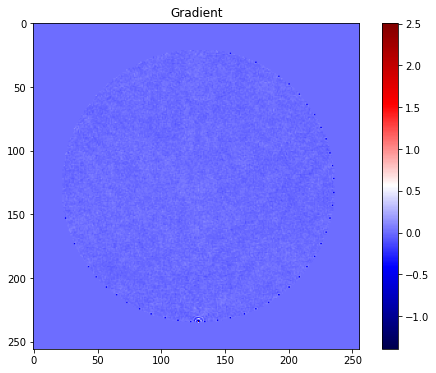

In [221]:
plt.figure(figsize=(8,6))
plt.imshow(gradient, cmap="seismic")
plt.colorbar()
plt.title("Gradient")

Text(0.5, 1.0, 'Gradient')

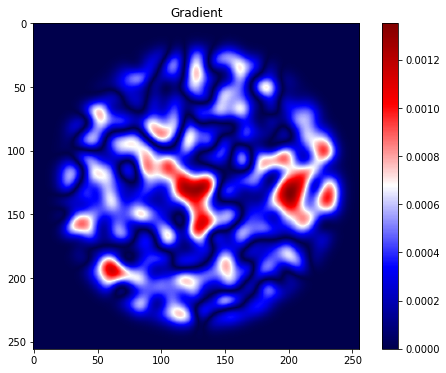

In [222]:
plt.figure(figsize=(8,6))
plt.imshow(jnp.abs(smooth(gradient,10)), cmap="seismic")
plt.colorbar()
plt.title("Gradient")

In [223]:
def relu(x):
    return jnp.where(x<0.,0.,x)

In [224]:
tv(medium.sound_speed)

DeviceArray(16.442379, dtype=float32)

  0%|          | 0/1000 [00:00<?, ?it/s]

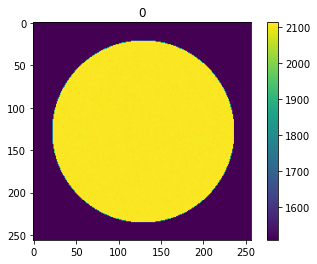

Loss: 107.7791 | TV: 11.2036 | Cutoff: 4.0:   1%|          | 10/1000 [00:49<1:12:37,  4.40s/it]

Loss: 106.6068 | TV: 10.9286 | Cutoff: 6.0:   2%|▏         | 20/1000 [01:33<1:12:36,  4.45s/it]

Loss: 100.1472 | TV: 10.9950 | Cutoff: 7.7:   3%|▎         | 30/1000 [02:19<1:14:31,  4.61s/it]

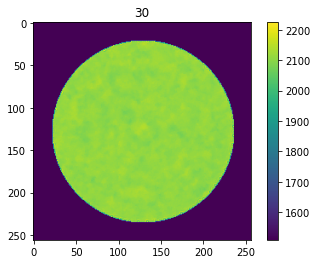

Loss: 93.8836 | TV: 11.0507 | Cutoff: 9.1:   4%|▍         | 40/1000 [03:03<1:09:59,  4.37s/it] 

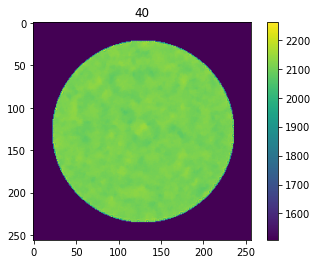

Loss: 99.8119 | TV: 11.2712 | Cutoff: 10.5:   5%|▌         | 50/1000 [03:48<1:10:03,  4.43s/it]

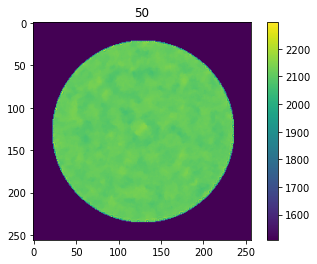

Loss: 92.3649 | TV: 11.4154 | Cutoff: 11.7:   6%|▌         | 60/1000 [04:36<1:13:23,  4.69s/it]

Loss: 87.0112 | TV: 11.6189 | Cutoff: 12.8:   7%|▋         | 70/1000 [05:20<1:07:19,  4.34s/it]

Loss: 86.0387 | TV: 11.8634 | Cutoff: 13.9:   8%|▊         | 80/1000 [06:05<1:09:59,  4.57s/it]

Loss: 92.2819 | TV: 12.0015 | Cutoff: 14.9:   9%|▉         | 90/1000 [06:49<1:05:22,  4.31s/it]

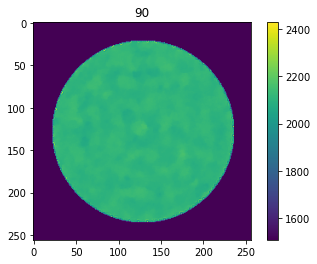

Loss: 88.1902 | TV: 12.3808 | Cutoff: 15.8:  10%|█         | 100/1000 [07:32<1:04:45,  4.32s/it]

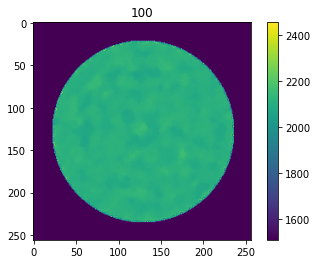

Loss: 89.7092 | TV: 12.6401 | Cutoff: 16.8:  11%|█         | 110/1000 [08:15<1:04:14,  4.33s/it]

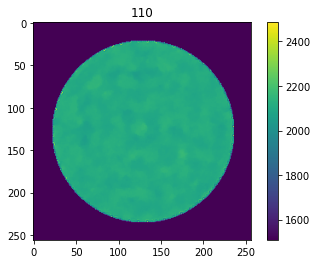

Loss: 81.6441 | TV: 12.8618 | Cutoff: 17.7:  12%|█▏        | 120/1000 [08:59<1:02:54,  4.29s/it]

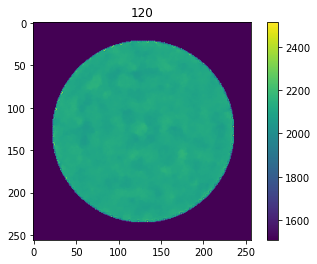

Loss: 87.4139 | TV: 12.9208 | Cutoff: 18.6:  13%|█▎        | 130/1000 [09:42<1:02:19,  4.30s/it]

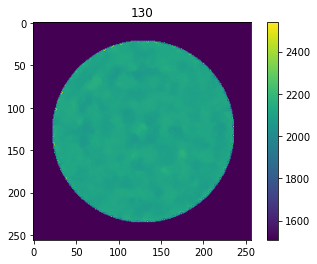

Loss: 86.2724 | TV: 12.9363 | Cutoff: 19.4:  14%|█▍        | 140/1000 [10:25<1:01:55,  4.32s/it]

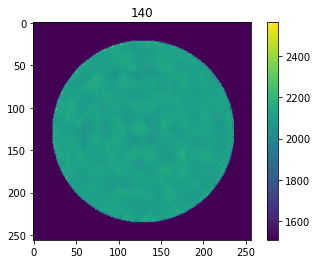

Loss: 86.6583 | TV: 13.1744 | Cutoff: 20.2:  15%|█▌        | 150/1000 [11:10<1:04:26,  4.55s/it]

Loss: 84.2234 | TV: 13.4105 | Cutoff: 21.0:  16%|█▌        | 160/1000 [11:55<1:01:30,  4.39s/it]

Loss: 84.5926 | TV: 13.4856 | Cutoff: 21.8:  17%|█▋        | 170/1000 [12:40<1:02:07,  4.49s/it]

Loss: 77.7002 | TV: 13.5660 | Cutoff: 22.6:  18%|█▊        | 180/1000 [13:25<1:01:29,  4.50s/it]

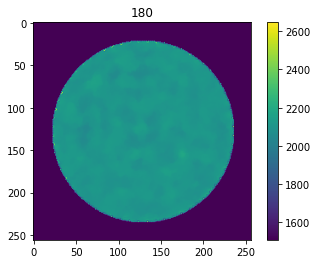

Loss: 78.9259 | TV: 13.5340 | Cutoff: 23.3:  19%|█▉        | 190/1000 [14:10<59:56,  4.44s/it]  

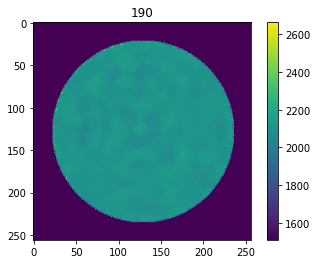

Loss: 81.2713 | TV: 13.5470 | Cutoff: 24.0:  20%|██        | 200/1000 [14:54<57:35,  4.32s/it]  

Loss: 81.6293 | TV: 13.6283 | Cutoff: 24.7:  21%|██        | 210/1000 [15:38<58:33,  4.45s/it]

Loss: 75.0286 | TV: 13.7030 | Cutoff: 25.4:  22%|██▏       | 220/1000 [16:22<57:13,  4.40s/it]

Loss: 81.3403 | TV: 13.7037 | Cutoff: 26.1:  23%|██▎       | 230/1000 [17:11<1:00:42,  4.73s/it]

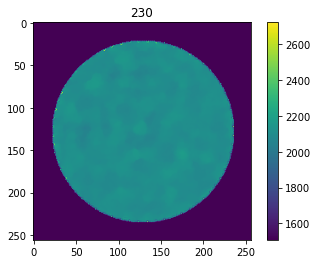

Loss: 73.9469 | TV: 13.8593 | Cutoff: 26.8:  24%|██▍       | 240/1000 [17:55<54:28,  4.30s/it]  

Loss: 70.9229 | TV: 13.8458 | Cutoff: 27.5:  25%|██▌       | 250/1000 [18:38<54:12,  4.34s/it]

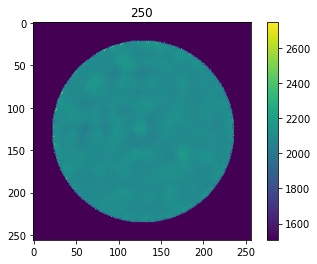

Loss: 75.5087 | TV: 13.9235 | Cutoff: 28.1:  26%|██▌       | 260/1000 [19:21<53:19,  4.32s/it]

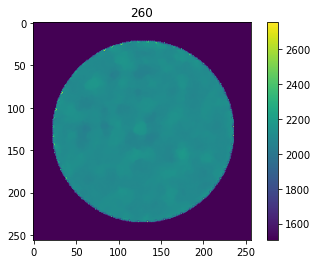

Loss: 70.8792 | TV: 14.0449 | Cutoff: 28.8:  27%|██▋       | 270/1000 [20:05<52:15,  4.30s/it]

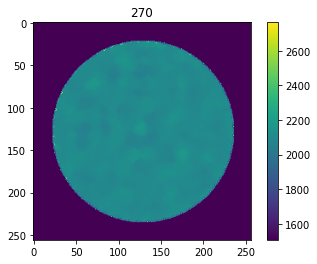

Loss: 76.8177 | TV: 14.0369 | Cutoff: 29.4:  28%|██▊       | 280/1000 [20:49<52:11,  4.35s/it]

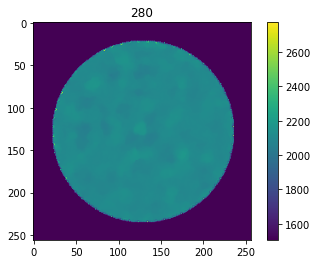

Loss: 75.4481 | TV: 14.1319 | Cutoff: 30.0:  29%|██▉       | 290/1000 [21:34<52:24,  4.43s/it]

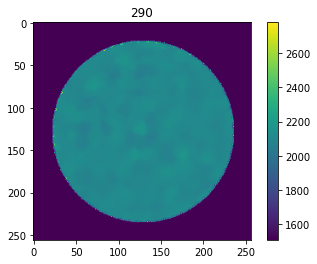

Loss: 75.5790 | TV: 14.2385 | Cutoff: 30.6:  30%|███       | 300/1000 [22:17<50:05,  4.29s/it]

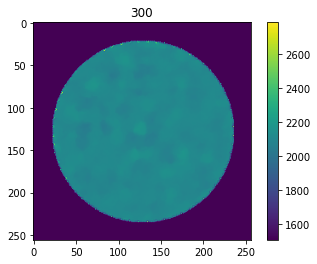

Loss: 75.8022 | TV: 14.2379 | Cutoff: 31.2:  31%|███       | 310/1000 [23:01<50:13,  4.37s/it]

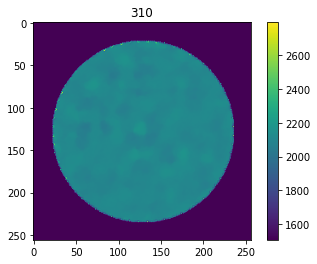

Loss: 72.1537 | TV: 14.2526 | Cutoff: 31.8:  32%|███▏      | 320/1000 [23:46<49:08,  4.34s/it]

Loss: 77.6214 | TV: 14.2034 | Cutoff: 32.4:  33%|███▎      | 330/1000 [24:28<47:55,  4.29s/it]

Loss: 73.1140 | TV: 14.2080 | Cutoff: 33.0:  34%|███▍      | 340/1000 [25:11<46:53,  4.26s/it]

Loss: 71.4343 | TV: 14.2386 | Cutoff: 33.6:  35%|███▌      | 350/1000 [25:56<48:25,  4.47s/it]

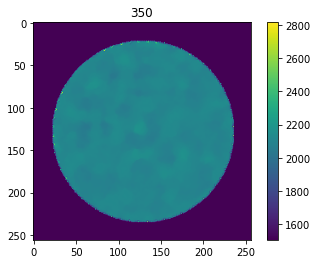

Loss: 76.0649 | TV: 14.1926 | Cutoff: 34.2:  36%|███▌      | 360/1000 [26:41<47:48,  4.48s/it]

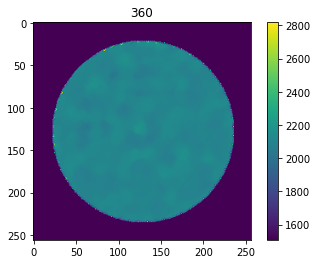

Loss: 74.1230 | TV: 14.4264 | Cutoff: 34.7:  37%|███▋      | 370/1000 [27:26<45:48,  4.36s/it]

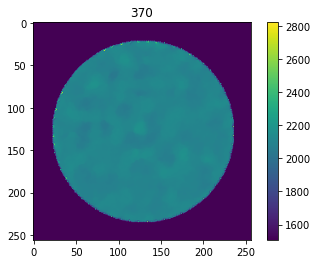

Loss: 75.1126 | TV: 14.3197 | Cutoff: 35.3:  38%|███▊      | 380/1000 [28:10<45:18,  4.38s/it]

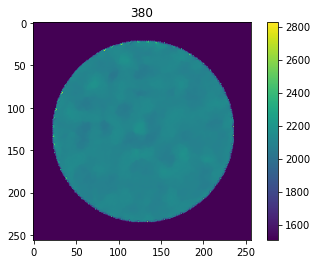

Loss: 72.0084 | TV: 14.2634 | Cutoff: 35.9:  39%|███▉      | 390/1000 [28:58<49:11,  4.84s/it]

Loss: 71.4174 | TV: 14.2740 | Cutoff: 36.4:  40%|████      | 400/1000 [29:42<43:31,  4.35s/it]

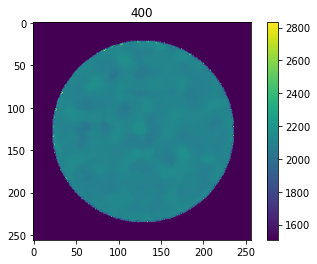

Loss: 78.3868 | TV: 14.1847 | Cutoff: 37.0:  41%|████      | 410/1000 [30:25<42:55,  4.37s/it]

Loss: 71.4834 | TV: 14.1941 | Cutoff: 37.5:  42%|████▏     | 420/1000 [31:08<41:21,  4.28s/it]

Loss: 71.5264 | TV: 14.2254 | Cutoff: 38.0:  43%|████▎     | 430/1000 [31:52<41:40,  4.39s/it]

Loss: 74.6981 | TV: 14.3589 | Cutoff: 38.6:  44%|████▍     | 440/1000 [32:36<41:29,  4.44s/it]

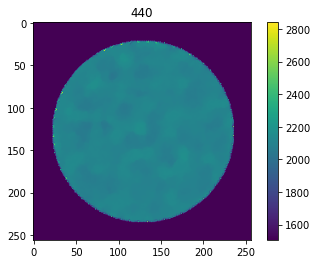

Loss: 75.2040 | TV: 14.4881 | Cutoff: 39.1:  45%|████▌     | 450/1000 [33:20<39:49,  4.35s/it]

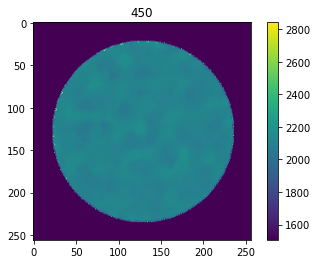

Loss: 71.7338 | TV: 14.4988 | Cutoff: 39.6:  46%|████▌     | 460/1000 [34:03<38:34,  4.29s/it]

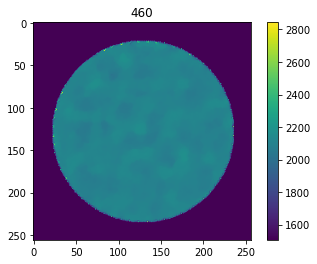

Loss: 69.6508 | TV: 14.4888 | Cutoff: 40.1:  47%|████▋     | 470/1000 [34:46<37:50,  4.28s/it]

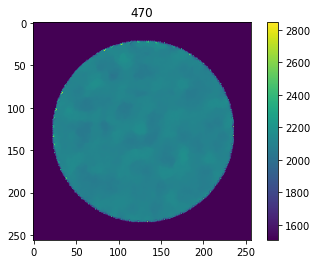

Loss: 74.9283 | TV: 14.4418 | Cutoff: 40.6:  48%|████▊     | 480/1000 [35:29<37:10,  4.29s/it]

Loss: 67.4202 | TV: 14.5993 | Cutoff: 41.1:  49%|████▉     | 490/1000 [36:12<36:10,  4.26s/it]

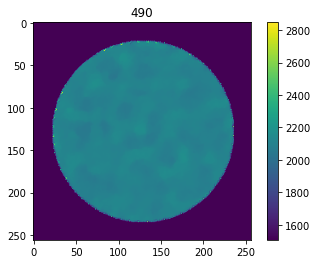

Loss: 76.8564 | TV: 14.5980 | Cutoff: 41.6:  50%|█████     | 500/1000 [36:55<35:39,  4.28s/it]

Loss: 71.8475 | TV: 14.4888 | Cutoff: 42.1:  51%|█████     | 510/1000 [37:38<34:48,  4.26s/it]

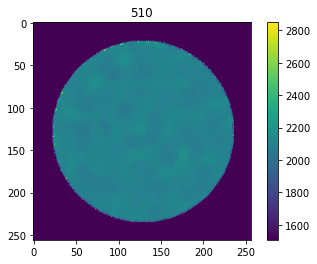

Loss: 73.1791 | TV: 14.4557 | Cutoff: 42.6:  52%|█████▏    | 520/1000 [38:21<34:13,  4.28s/it]

Loss: 78.3638 | TV: 14.4733 | Cutoff: 43.1:  53%|█████▎    | 530/1000 [39:04<33:27,  4.27s/it]

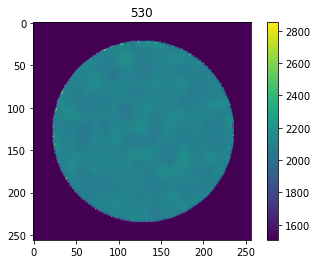

Loss: 71.6618 | TV: 14.4810 | Cutoff: 43.6:  54%|█████▍    | 540/1000 [39:48<35:30,  4.63s/it]

Loss: 74.9564 | TV: 14.4306 | Cutoff: 44.1:  55%|█████▌    | 550/1000 [40:36<33:34,  4.48s/it]

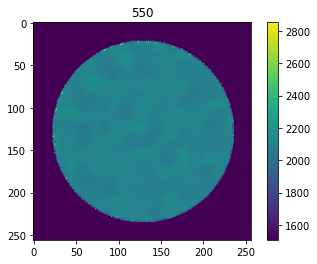

Loss: 74.0827 | TV: 14.4634 | Cutoff: 44.6:  56%|█████▌    | 560/1000 [41:20<32:56,  4.49s/it]

Loss: 69.0030 | TV: 14.5321 | Cutoff: 45.0:  57%|█████▋    | 570/1000 [42:04<32:07,  4.48s/it]

Loss: 77.7399 | TV: 14.5283 | Cutoff: 45.5:  58%|█████▊    | 580/1000 [42:48<30:12,  4.32s/it]

Loss: 67.9587 | TV: 14.5874 | Cutoff: 46.0:  59%|█████▉    | 590/1000 [43:32<30:52,  4.52s/it]

Loss: 72.3477 | TV: 14.4811 | Cutoff: 46.4:  60%|██████    | 600/1000 [44:16<30:11,  4.53s/it]

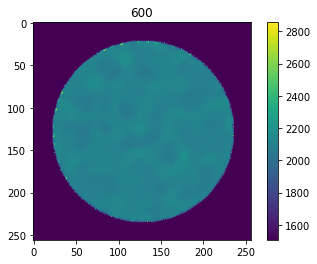

Loss: 77.0028 | TV: 14.5532 | Cutoff: 46.9:  61%|██████    | 610/1000 [45:00<27:59,  4.31s/it]

Loss: 71.6479 | TV: 14.5589 | Cutoff: 47.4:  62%|██████▏   | 620/1000 [45:44<28:32,  4.51s/it]

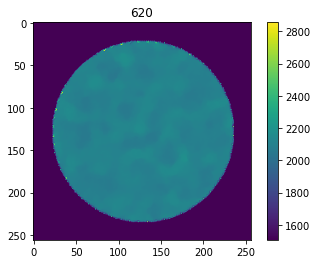

Loss: 71.1762 | TV: 14.5169 | Cutoff: 47.8:  63%|██████▎   | 630/1000 [46:30<27:03,  4.39s/it]

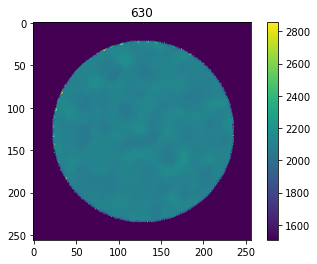

Loss: 74.1617 | TV: 14.6008 | Cutoff: 48.3:  64%|██████▍   | 640/1000 [47:14<26:08,  4.36s/it]

Loss: 72.7106 | TV: 14.6081 | Cutoff: 48.7:  65%|██████▌   | 650/1000 [47:58<25:10,  4.32s/it]

Loss: 71.9891 | TV: 14.6722 | Cutoff: 49.2:  66%|██████▌   | 660/1000 [48:43<26:02,  4.60s/it]

Loss: 70.3215 | TV: 14.6880 | Cutoff: 49.6:  67%|██████▋   | 670/1000 [49:27<23:54,  4.35s/it]

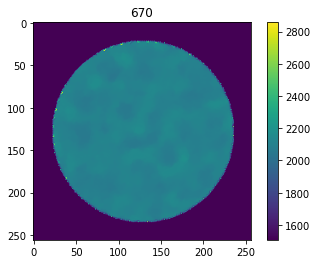

Loss: 73.9714 | TV: 14.5658 | Cutoff: 50.1:  68%|██████▊   | 680/1000 [50:12<24:01,  4.51s/it]

Loss: 67.1639 | TV: 14.6015 | Cutoff: 50.5:  69%|██████▉   | 690/1000 [50:59<23:03,  4.46s/it]

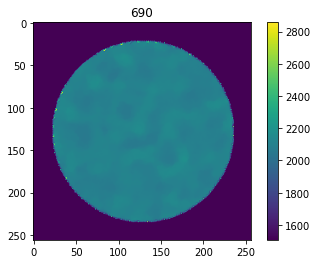

Loss: 74.2317 | TV: 14.5995 | Cutoff: 50.9:  70%|███████   | 700/1000 [51:44<21:51,  4.37s/it]

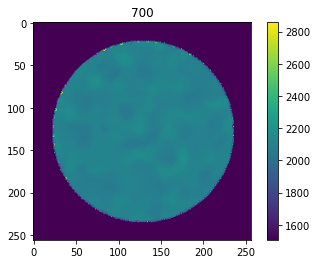

Loss: 70.8565 | TV: 14.7115 | Cutoff: 51.4:  71%|███████   | 710/1000 [52:28<20:46,  4.30s/it]

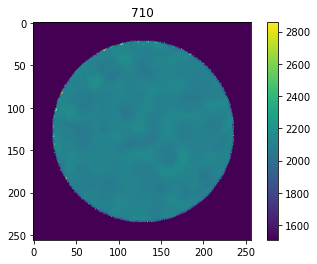

Loss: 69.4393 | TV: 14.6985 | Cutoff: 51.8:  72%|███████▏  | 720/1000 [53:12<20:39,  4.43s/it]

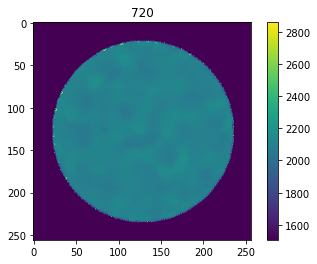

Loss: 68.2431 | TV: 14.7954 | Cutoff: 52.2:  73%|███████▎  | 730/1000 [53:58<19:54,  4.42s/it]

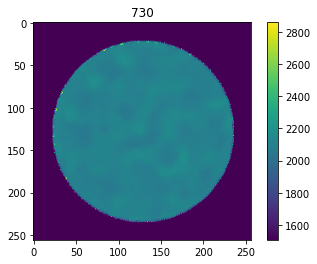

Loss: 70.5310 | TV: 14.7527 | Cutoff: 52.7:  74%|███████▍  | 740/1000 [54:41<19:09,  4.42s/it]

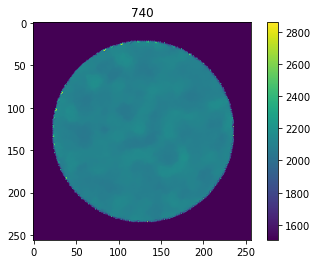

Loss: 71.2109 | TV: 14.7473 | Cutoff: 53.1:  75%|███████▌  | 750/1000 [55:26<18:19,  4.40s/it]

Loss: 70.5738 | TV: 14.7103 | Cutoff: 53.5:  76%|███████▌  | 760/1000 [56:09<17:09,  4.29s/it]

Loss: 68.4313 | TV: 14.7465 | Cutoff: 53.9:  77%|███████▋  | 770/1000 [56:53<16:31,  4.31s/it]

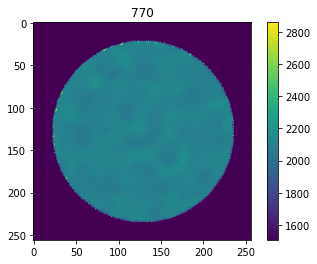

Loss: 69.9672 | TV: 14.7723 | Cutoff: 54.4:  78%|███████▊  | 780/1000 [57:38<16:49,  4.59s/it]

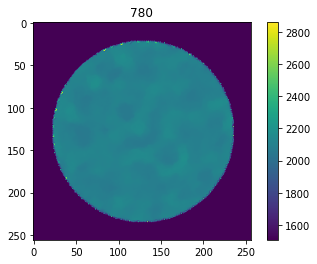

Loss: 72.9538 | TV: 14.7368 | Cutoff: 54.8:  79%|███████▉  | 790/1000 [58:22<15:13,  4.35s/it]

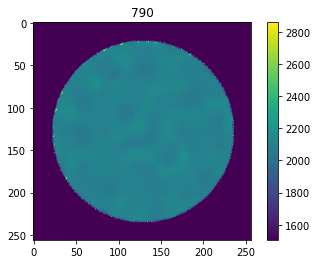

Loss: 67.8636 | TV: 14.7498 | Cutoff: 55.2:  80%|████████  | 800/1000 [59:05<14:21,  4.31s/it]

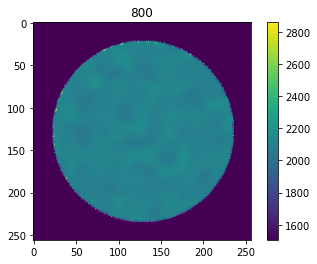

Loss: 68.7929 | TV: 14.7681 | Cutoff: 55.6:  81%|████████  | 810/1000 [59:49<13:36,  4.30s/it]

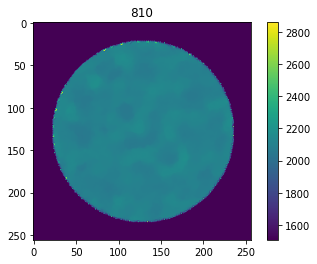

Loss: 69.7594 | TV: 14.8797 | Cutoff: 56.0:  82%|████████▏ | 820/1000 [1:00:36<14:27,  4.82s/it]

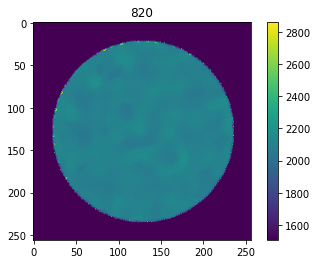

Loss: 68.9258 | TV: 14.7675 | Cutoff: 56.4:  83%|████████▎ | 830/1000 [1:01:21<12:21,  4.36s/it]

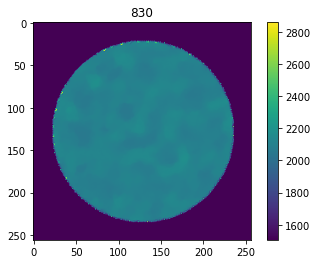

Loss: 70.0154 | TV: 14.8749 | Cutoff: 57.6:  86%|████████▌ | 860/1000 [1:03:35<10:36,  4.55s/it]

Loss: 66.4655 | TV: 14.8009 | Cutoff: 58.0:  87%|████████▋ | 870/1000 [1:04:19<09:17,  4.29s/it]

Loss: 71.7279 | TV: 14.8367 | Cutoff: 58.4:  88%|████████▊ | 880/1000 [1:05:02<08:32,  4.27s/it]

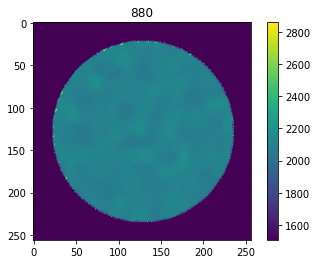

Loss: 74.1184 | TV: 14.9715 | Cutoff: 58.8:  89%|████████▉ | 890/1000 [1:05:46<08:18,  4.53s/it]

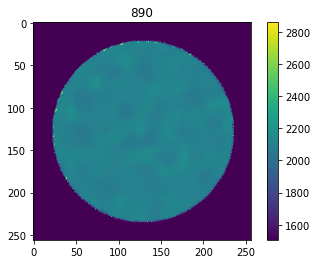

Loss: 72.0769 | TV: 14.8653 | Cutoff: 59.2:  90%|█████████ | 900/1000 [1:06:31<07:14,  4.35s/it]

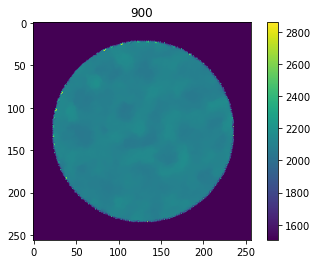

Loss: 73.6339 | TV: 14.8718 | Cutoff: 59.6:  91%|█████████ | 910/1000 [1:07:15<06:37,  4.42s/it]

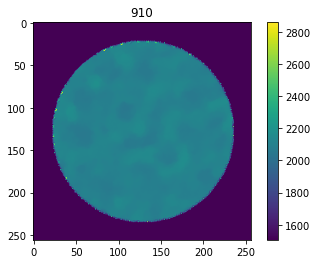

Loss: 66.5432 | TV: 14.8933 | Cutoff: 60.0:  92%|█████████▏| 920/1000 [1:08:00<05:53,  4.41s/it]

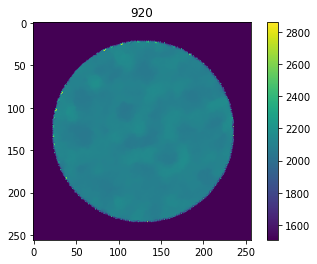

Loss: 75.4625 | TV: 14.8892 | Cutoff: 60.4:  93%|█████████▎| 930/1000 [1:08:45<05:21,  4.59s/it]

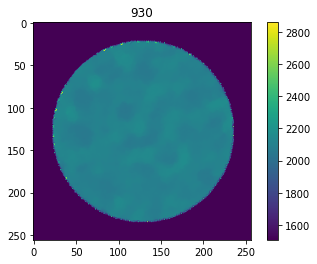

Loss: 68.3917 | TV: 14.9071 | Cutoff: 60.4:  93%|█████████▎| 931/1000 [1:08:50<05:21,  4.66s/it]

In [ ]:
losshistory = []
reconstructions = []

init_fun, update_fun, get_params = optimizers.adam(.01, 0.9, 0.9)
opt_state = init_fun(params)

@jax.jit
def update(opt_state, key, k):
    v = get_params(opt_state)
    
    # Splitting sources in a 4 by 8 matrix.
    # Each GPU will process 2 sources in parallel
    src_num = random.choice(key, num_sources, shape=(jax.device_count(),1,), replace=False)
    
    # Running entire gradient computation in parallel, with each
    # gpu doing 4 simulations in parallel
    lossvals, total_variation, gradients = jax.pmap(
        jax.vmap(loss_with_grad, in_axes=(None,0)), 
        in_axes=(None,0)
    )(v, src_num)
    
    # Only moves data to host to take averages
    gradient = jnp.mean(gradients, axis=(0,1))
    lossval = jnp.mean(lossvals, axis=(0,1))
    total_variation = jnp.mean(total_variation)
    
    # Weighting full gradients and smoothed gradients
    a = (k-200.)/200.
    sos = get_sound_speed(v)
    gradient = jnp.where(sos <= 1509, -jnp.abs(gradient), gradient)
    return lossval, total_variation, update_fun(k, gradient*mask, opt_state)

#pbar = tqdm(range(1000))
_, key = random.split(random.PRNGKey(32))
pbar = tqdm(range(1000))
for k in pbar:
    _, key = random.split(key)
    lossval, total_variation, opt_state = update(opt_state, key, float(k))
    
    # For logging
    new_params = get_params(opt_state)
    reconstructions.append(np.array(get_sound_speed(new_params)))
    losshistory.append(lossval)
    
    if k % 10 == 0:
        plt.imshow(reconstructions[-1])
        plt.title("{}".format(k))
        plt.colorbar()
        plt.show()
    
    pbar.set_description("Loss: {:01.4f} | TV: {:01.4f} | Cutoff: {:01.1f}".format(lossval, total_variation, (k+1)**0.6))

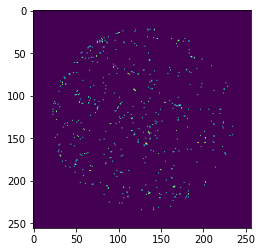

In [108]:
plt.imshow(reconstructions[-1]<1509)

In [109]:
new_params = get_params(opt_state)

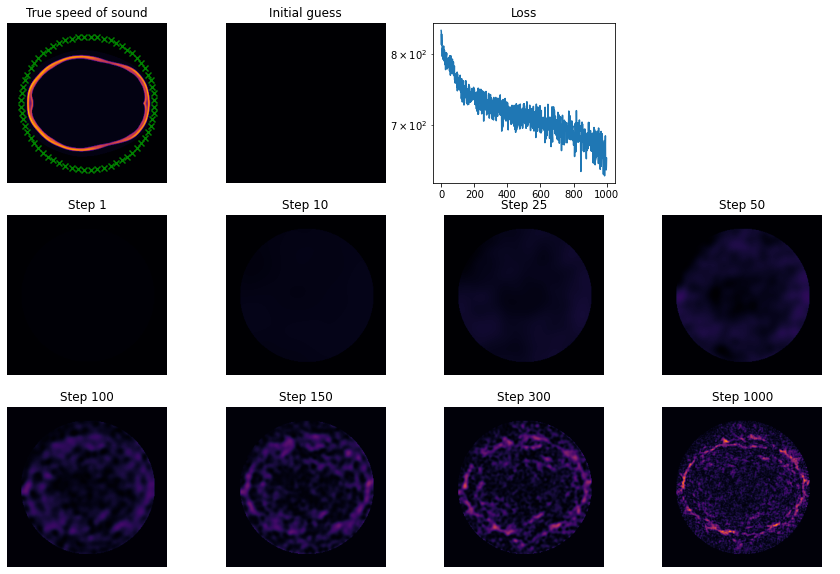

In [113]:
sos_original = get_sound_speed(params)
true_sos = sound_speed

fig, axes = plt.subplots(3,4, figsize=(15,10))

k = 0
recs = list(map(lambda x: x-1, [1, 10, 25, 50, 100, 150, 300, 1000]))
#recs = list(map(lambda x: x-1, [10,20,30,40, 50, 60,75, 95]))
for row in range(3):
    for col in range(4):
        if k ==0:
            axes[row,col].imshow(true_sos, vmax=2700, cmap="inferno")
            axes[row,col].scatter(sensors_positions[1],sensors_positions[0], c='g', marker='x', label="sensors")
            axes[row,col].set_title("True speed of sound")
            axes[row,col].set_axis_off()
        elif k ==1:
            axes[row,col].imshow(sos_original, vmax=2700, cmap="inferno")
            axes[row,col].set_axis_off()
            axes[row,col].set_title("Initial guess")
        elif k ==2:
            axes[row,col].plot(losshistory)
            axes[row,col].set_title("Loss")
            axes[row,col].set_yscale("log")
        elif k == 3:
            axes[row,col].set_axis_off()
        else:
            axes[row,col].imshow(reconstructions[recs[k-4]], vmax=2700, cmap="inferno")
            axes[row,col].set_axis_off()
            axes[row,col].set_title("Step {}".format(recs[k-4]+1))
        k += 1

In [ ]:
sos_original = get_sound_speed(params)
true_sos = sound_speed

fig, axes = plt.subplots(3,4, figsize=(15,10))

k = 0
recs = list(map(lambda x: x-1, [1, 10, 25, 50, 100, 200, 350, 500]))
for row in range(3):
    for col in range(4):
        if k ==0:
            axes[row,col].imshow(true_sos, vmax=1.7, cmap="inferno")
            axes[row,col].scatter(sensors_positions[1],sensors_positions[0], c='g', marker='x', label="sensors")
            axes[row,col].set_title("True speed of sound")
            axes[row,col].set_axis_off()
        elif k ==1:
            axes[row,col].imshow(sos_original, vmax=1.7, cmap="inferno")
            axes[row,col].set_axis_off()
            axes[row,col].set_title("Initial guess")
        elif k ==2:
            axes[row,col].plot(losshistory)
            axes[row,col].set_title("Loss")
            axes[row,col].set_yscale("log")
        elif k == 3:
            axes[row,col].set_axis_off()
        else:
            axes[row,col].imshow(reconstructions[recs[k-4]], vmax=1.7, cmap="inferno")
            axes[row,col].set_axis_off()
            axes[row,col].set_title("Step {}".format(recs[k-4]+1))
        k += 1